# Implementation of Linear regression

## 1. PCA : Transforming data into 2 prinicpal componants (subspace) 
## 2. Apply Linear regression
Source: Digit.zip
https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz

In [112]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.exists("zip.train"):
  ! wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz
  ! gunzip zip.train.gz
    
if not os.path.exists("zip.test"):
  ! wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz
  ! gunzip zip.test.gz

In [113]:
def load_from_file(path):
  df = pd.read_csv(path, header=None, sep=" ")
  X = df.iloc[:, 1:257].values
  y = df.iloc[:, 0].values
  return X, y

X_train, y_train = load_from_file("zip.train")
print("N_train = {}".format(len(X_train)))
X_test, y_test = load_from_file("zip.test")
print("N_test = {}".format(len(X_test)))

N_train = 7291
N_test = 2007


# Data Visualisation

In [114]:
num_samples = 20
indices = np.random.choice(range(len(X_train)), num_samples)
sample_digits = X_train[indices]
sample_labels = y_train[indices]

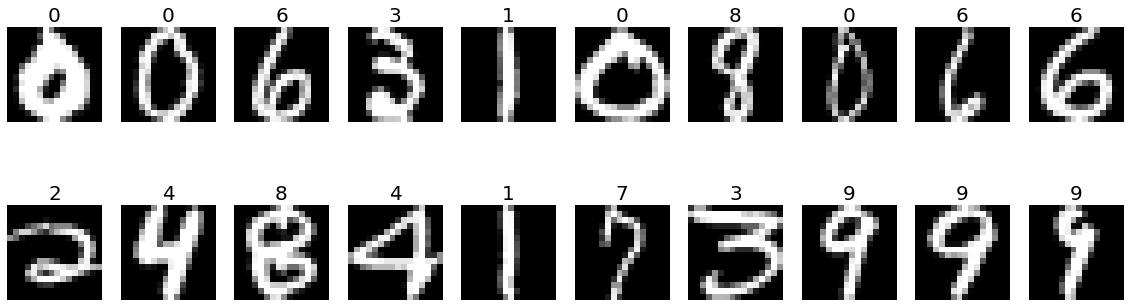

In [115]:
fig = plt.figure(figsize=(20, 6))
for i in range(num_samples):
    ax = plt.subplot(2, 10, i + 1)
    img = sample_digits[i].reshape((16, 16))
    plt.imshow(img, cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis('off')
    plt.title(int(sample_labels[i]), size=20)

# Principal Componant analysis (PCA)

In [116]:
# covariance matrix calculated in a loop 
#(sum of outer vector products of the centered data points)
def covariance_matrix(X):
    num_samples, _ = X.shape
    mu = np.mean(X, axis=0)
    X_centered = X - mu
    return X_centered.T.dot(X_centered) / num_samples

In [117]:
class PCA:
    
    def __init__(self, num_components):
        self.num_components = num_components
        
    def fit(self, X):
        Xcov = covariance_matrix(X)
        eigh_val_, eigh_vec_ = np.linalg.eigh(Xcov)
        #eigh output in ascending order
        eigh_vec_desc = np.flip(eigh_vec_, axis=1)
        self.components = eigh_vec_desc[:, :self.num_components]
        
    def transform(self, X):
        self.fit(X)
        return np.dot(X, self.components)

In [118]:
pca = PCA(2)
pca.fit(X_train)

X_trn_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

## Training dataset visualisation 

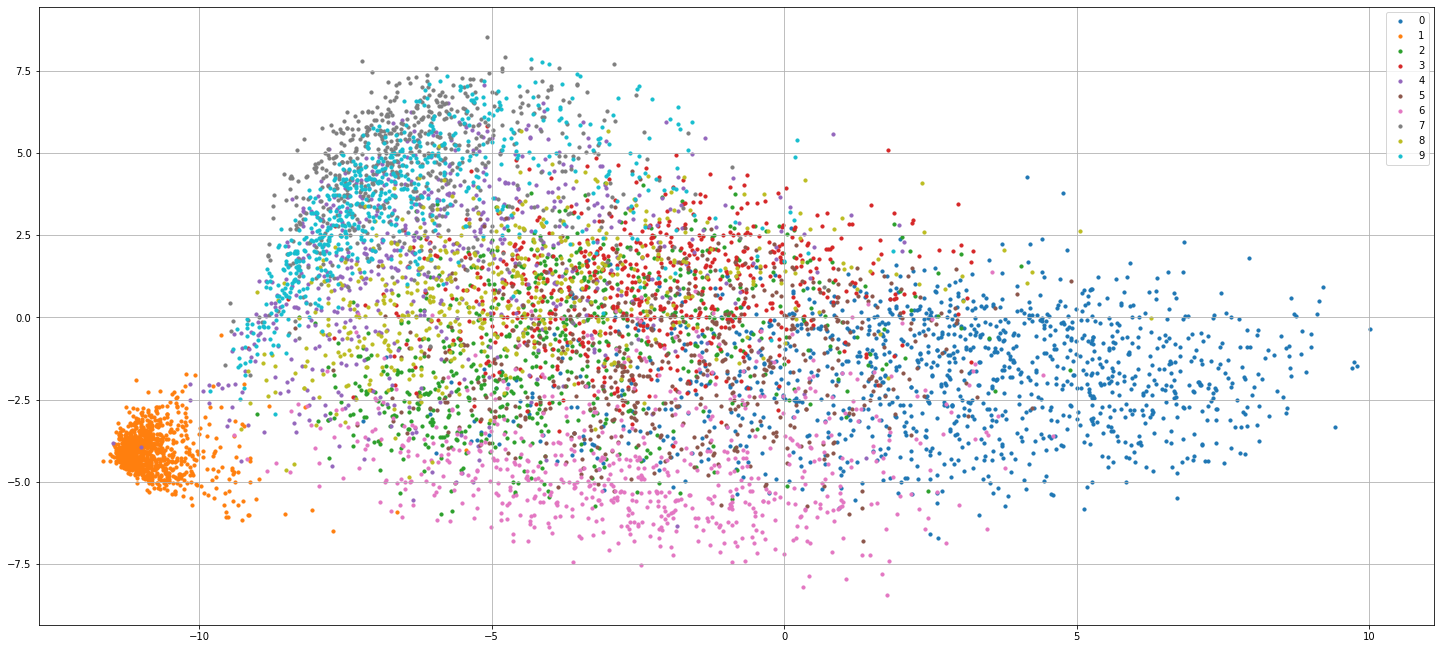

In [119]:
fig = plt.figure(figsize=(25, 25))
plt.subplot(2, 1, 1)
for i in range(10):
    X_i = X_trn_reduced[y_train == i]
    plt.scatter(X_i[:, 0], X_i[:, 1], s=10.0, label=i)
    
plt.grid()
plt.legend()
plt.show()

In [120]:
def plt_2_classes(X, y, class_1, class_2):
    X1 = X[y == class_1]
    plt.scatter (X1[:, 0], X1[:, 1], s=1, label=class_1)
    X2 = X[y == class_2]
    plt.scatter (X2[:, 0], X2[:, 1], s=1, label=class_2)
    plt.title(str(class_1) +' vs ' + str(class_2))

In [121]:
def plt_all_combination(X, y):
    fig = plt.figure(figsize=(25, 50))
    
    plot_index = 1
    for i in range(10):
        for j in range(i+1, 10):
            ax = plt.subplot(9, 5, plot_index)
            plot_index += 1
            plt_2_classes(X, y, i, j)
    plt.show()

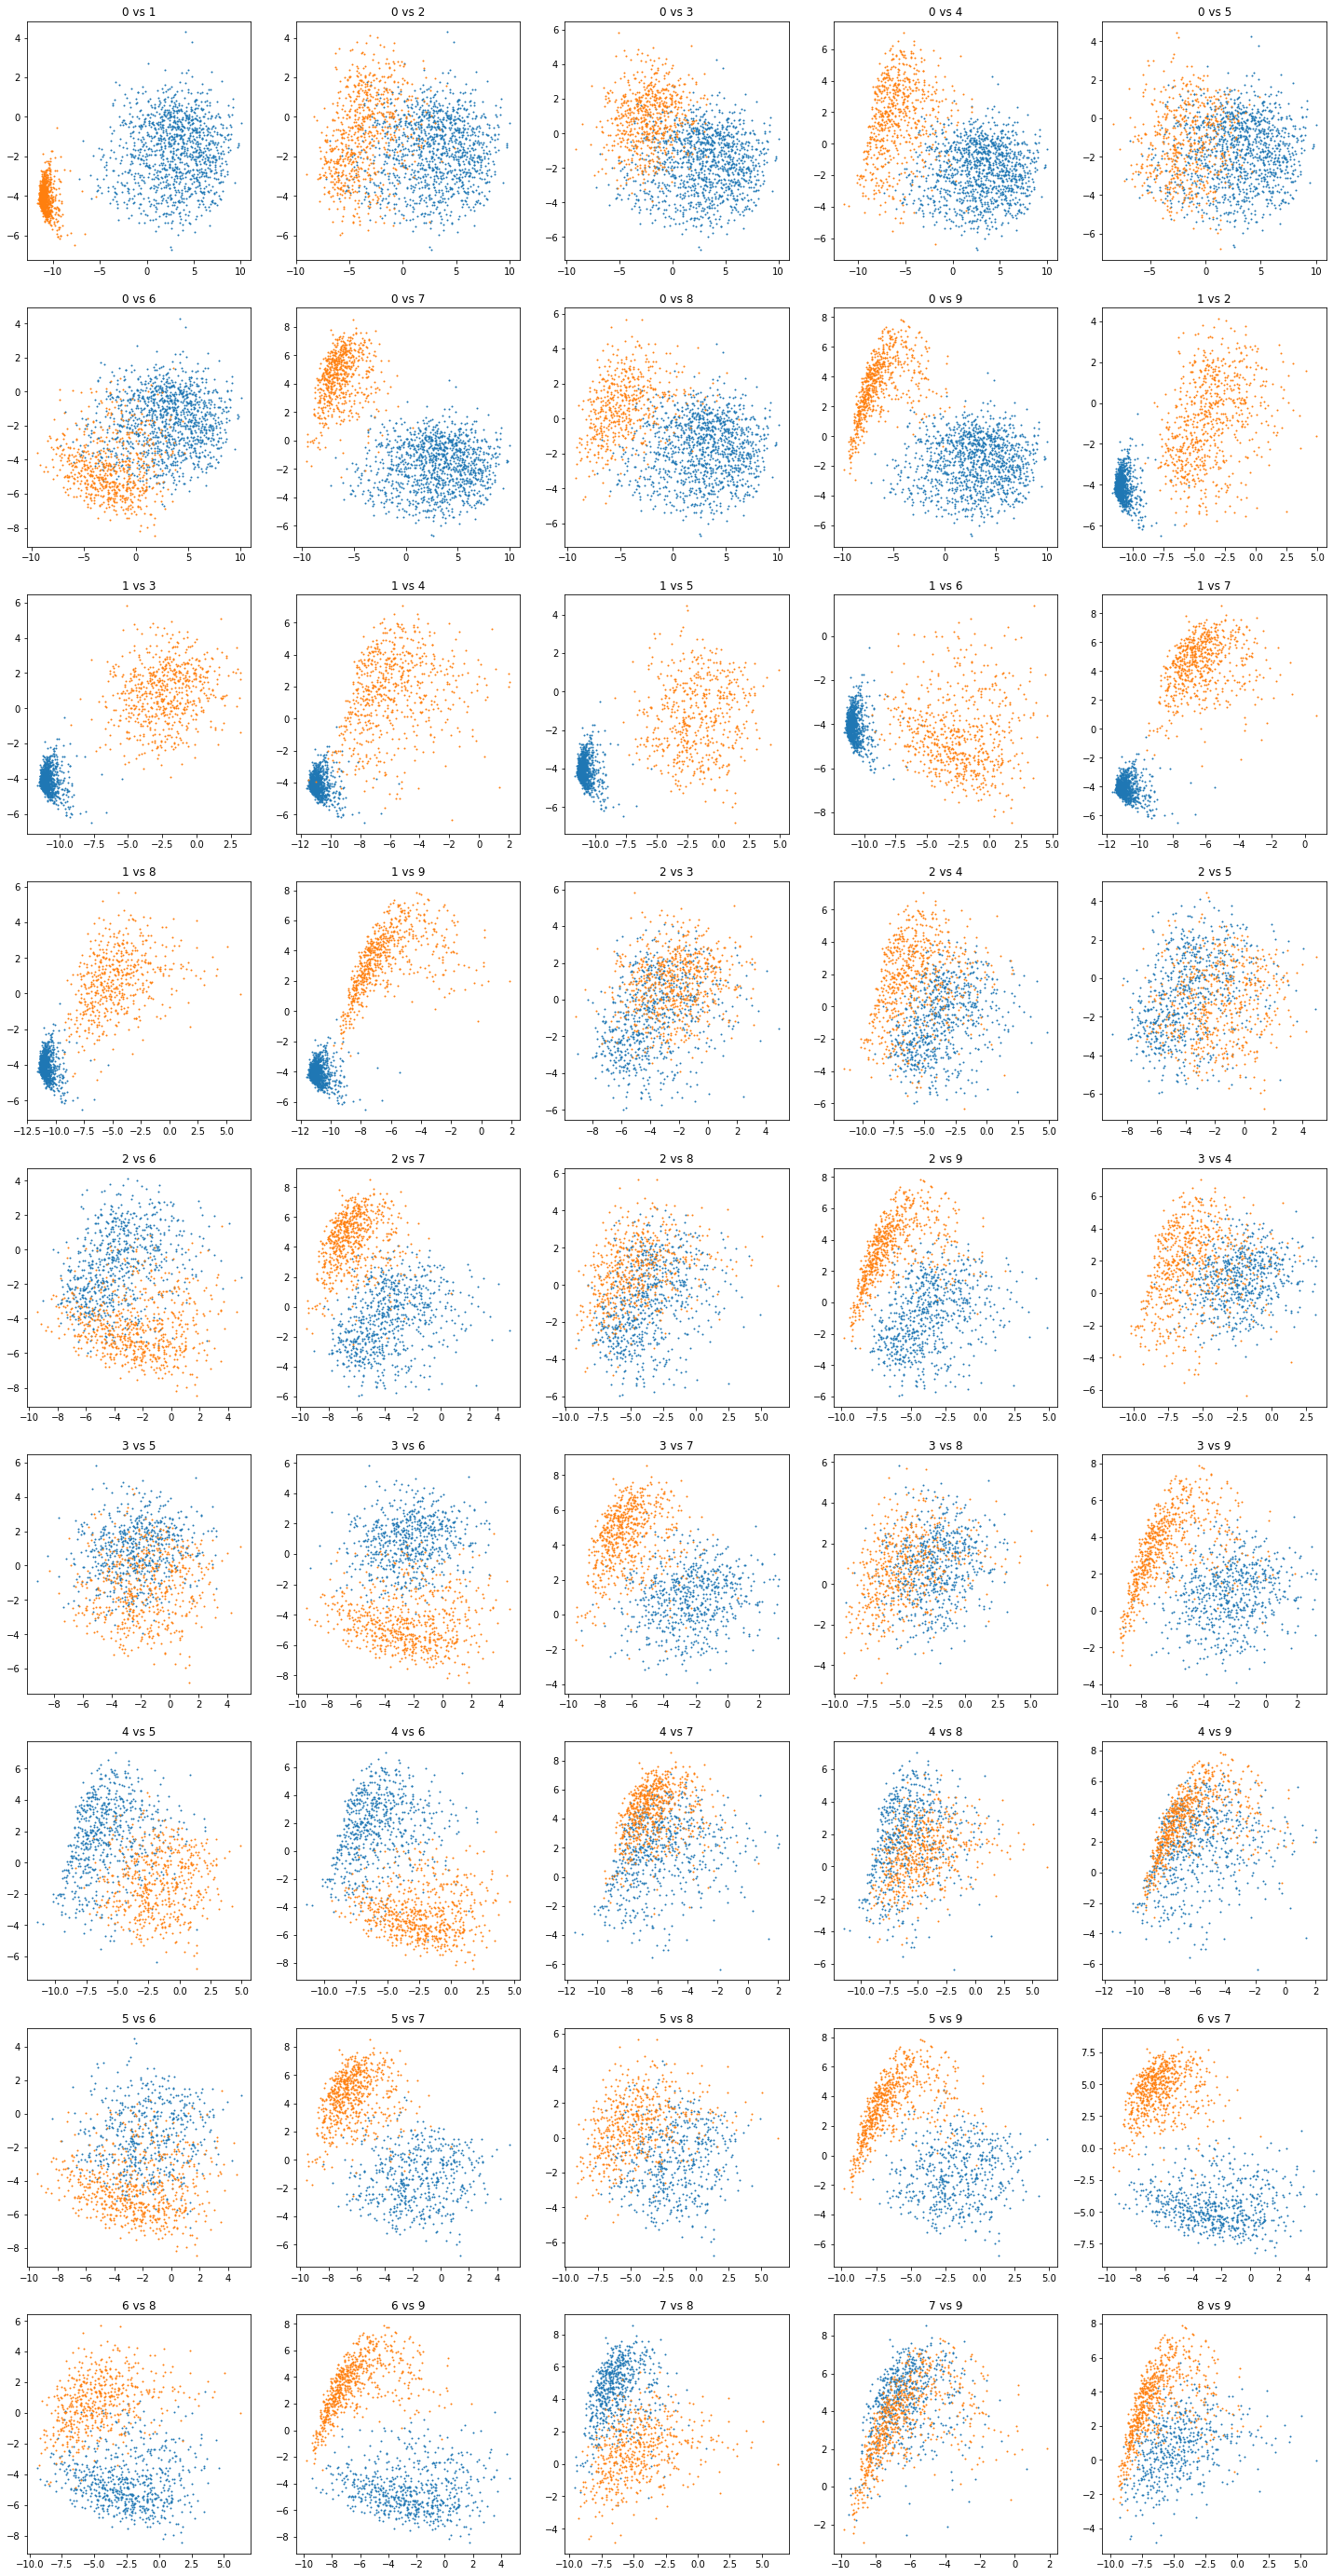

In [122]:
plt_all_combination(X_trn_reduced, y_train)

# Linear Regression 

### Perform Linear regression on Transformed data (using PCA) and show it with two individual classes

In [123]:
class Linear_regression:
    def __init__(self):
        self.beta = None
        
    def add_ones(self, X):
        return np.concatenate((np.ones((len(X), 1)), X), axis=1)
    
    def fit(self, X, y):
        X = self.add_ones(X)
        self.beta = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    
    def predict(self, X, y):
        X = self.add_ones(X)
        return X.dot(self.beta)

In [124]:
def prepare_data(X, y, class0, class1):
    #Divide data with class0 as 0 and class1 as 1
    X0 = X[y==class0]
    X1 = X[y==class1]
    X01 = np.concatenate((X0, X1))
    y01 = np.concatenate((np.zeros(len(X0)), np.ones(len(X1))))
    return X01, y01

### Linear regression for two classes with labels 1 and 2

In [150]:
lr = Linear_regression()

# divide data into desired two classes (class 1, class 2)
X01, y01 = prepare_data(X_trn_reduced, y_train, 1, 2)
X01_test, y01_true = prepare_data(X_test_reduced, y_test, 1, 2)

# weight vectors set with train_set
lr.fit(X01, y01)

# score : predict for test test
y_pred_test = lr.predict(X01_test, y01_true)

# decision boundary as 0.5 and score
y_pred_test[y_pred_test < 0.5] = 0
y_pred_test[y_pred_test >= 0.5] = 1

score = np.mean(y_pred_test == y01_true)

### plot test data with decision boundary

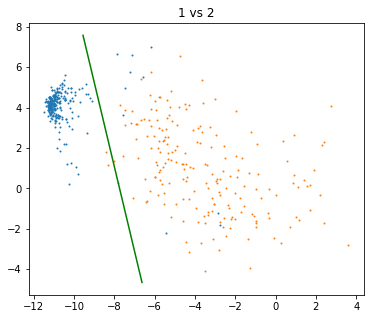

---- score: 0.971861 ------


In [153]:
fig = plt.figure(figsize=(6, 5))

plt_2_classes(X_test_reduced, y_test, class_1=1, class_2=2)
        
# compute two points on decision boundary (y=0.5)
w0, w1, w2 = lr.beta[0], lr.beta[1], lr.beta[2]
        
if (abs(w1) < abs(w2)):
    # vertical decision boundary
    X1 = plt.xlim() # min/max x1 of points
    X2 = [(0.5 - w0 - w1 * x1) / w2 for x1 in X1]
else:
    # horizontal decision boundary
    X2 = plt.ylim()  # min/max x2 of points
    X1 = [(0.5 - w0 - w2 * x2) / w1 for x2 in X2]
    
plt.plot(X1, X2, color='green' )
plt.show()
print("---- score: %f ------" % (score))